<a href="https://colab.research.google.com/github/lucianomcsilva/RIWRS/blob/main/Valor_real_do_d%C3%B3lar_em_reais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As primeiras coisas primeiro. Vamos no site do Banco Central baixar a cotação do dólar por real, inciando no dia primeiro de julho de 1.994, junto com o plano real.

Pegar a cotação anterior a essa exigira fazer as conversoes de moeda, e como ja temos quase 30 anos de dados, acho que serão suficientes para avaliar minha hipotese.



In [23]:
import pandas as pd

#importa os valores da cotacao diretamente do site do banco central.
#Ajustes de formato, devido a localizacao para o portugues brasileiro
cotacao = pd.read_csv("http://api.bcb.gov.br/dados/serie/bcdata.sgs.10813/dados?formato=csv&dataInicial=01/07/1994&dataFinal=31/01/2023", delimiter=';', quotechar='"', decimal=',')


Quebrando em duas paginas, para nao ficar carregando desnecessáriamente os dados do BACEN, enquanto a gente faz a limpeza e tratamento dos dados

In [24]:
#Convertendo a data, que esta formatada em string/object 
cotacao['data'].head()

#em data de verdade
cotacao['data_cotacao'] = pd.to_datetime(cotacao['data'], format='%d/%m/%Y')

# para facilitar algumas operações, criando as colunas de mes e ano
cotacao['numero_mes'] = pd.DatetimeIndex(cotacao['data_cotacao']).month
cotacao['numero_ano'] = pd.DatetimeIndex(cotacao['data_cotacao']).year

#E para deixar organizado os nomes das colunas
cotacao['valor_cotacao'] = cotacao['valor'] 

#limpando as colunas originais, que nao quero mais usar
cotacao = cotacao[['data_cotacao', 'numero_mes', 'numero_ano', 'valor_cotacao']]

#vendo como ficou
cotacao.head()


,data_cotacao,numero_mes,numero_ano,valor_cotacao
0,1994-07-01,7,1994,0.900
1,1994-07-04,7,1994,0.935
2,1994-07-05,7,1994,0.927
3,1994-07-06,7,1994,0.910
4,1994-07-07,7,1994,0.905



Agora que consegui limpar os dados, vamos plotar o grafico. Afinal, graficos são sempre mais legais!



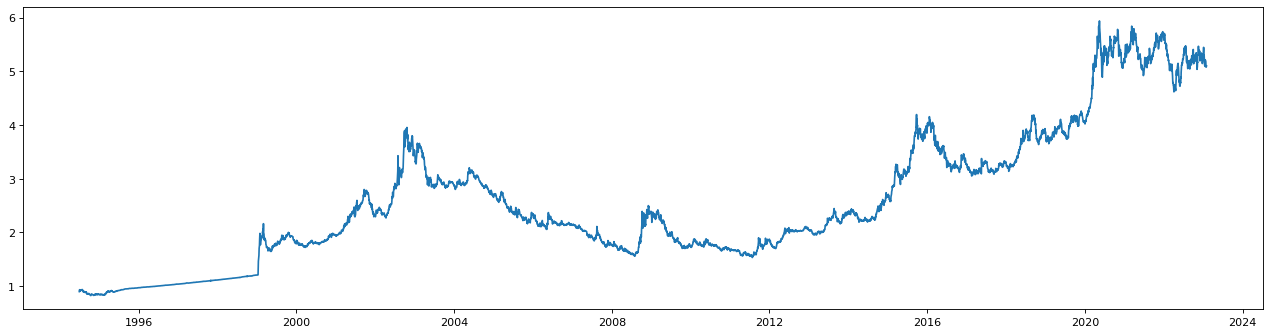

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5), dpi=80)
plt.plot(cotacao['data_cotacao'], cotacao['valor_cotacao'], '-')
plt.show()

Funciona! Agora vamos avaliar, de forma bem inocente, o comportamento dessa curva, se ela fosse linear.

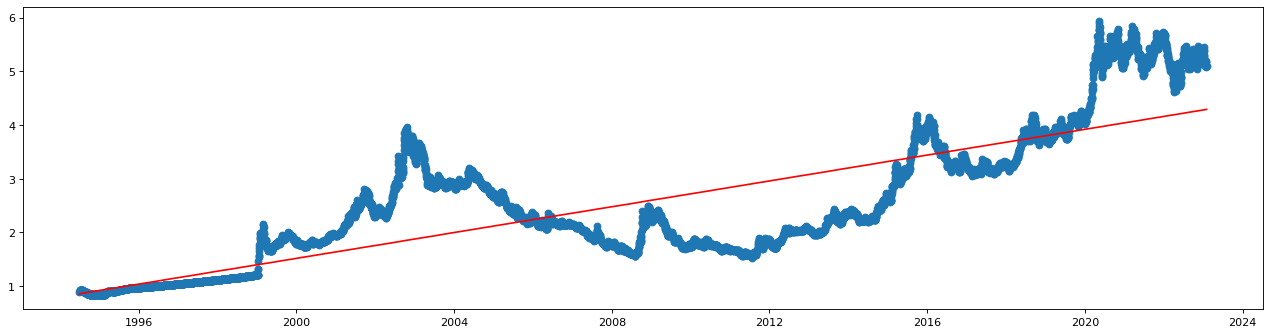

A equação prevista é Y = [0.85954114] + X * [[0.00047816]] com um R2 de 0.6334186456758758


In [26]:
#thanks to https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d
from sklearn.linear_model import LinearRegression

df = cotacao[['valor_cotacao']]
df.reset_index(level=0, inplace=True)

#Ajusta o formato dos dados, e faz projecao linear
X = df.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

#Agora mostra os valores
plt.figure(figsize=(20, 5), dpi=80)
plt.scatter(cotacao['data_cotacao'], Y)
plt.plot(cotacao['data_cotacao'], Y_pred, color='red')
plt.show()

#Mostrando dados da equação
print(f"A equação prevista é Y = {linear_regressor.intercept_} + X * {linear_regressor.coef_} com um R2 de {linear_regressor.score(X, Y) }")



Obviamente o resultado acima é muito ruim, e não é a hipotese que queremos testar. Mas foi apenas para comecar.

Em teoria, o valor do real em 1994 não é o mesmo do valor hoje. Para efeito de comparação, em 1994, no inicio do plano real, um salario minimo era 70,00 reais. O salário minimo subiu muito, e em 2.021 está valendo 1.100,00 reais. Um aumento de quase 1600%.

Isso ocorreu pela correção da inflação. Evidemente não foi apenas isso, houveram inumeros avanços sociais no aumento real do salário mínimo em vários governos (não vamos falar de politica). Mas para dar um outro exemplo que por algum motivo extranho ficou marcado na minha memoria, no inicio do plano real um carro popular custava no brasil cerca de 7.500,00 (uno Mile). E isso era verdade para diversos outros carros, como Gol 1000, Escort Hobby.

Então proximo passo, correção da inflação.

In [27]:
#importa os valores da cotacao diretamente do site do banco central.
#Ajustes de formato, devido a localizacao para o portugues brasileiro
inflacao = pd.read_csv("http://api.bcb.gov.br/dados/serie/bcdata.sgs.4466/dados?formato=csv&dataInicial=01/07/1994&dataFinal=31/01/2023", delimiter=';', quotechar='"', decimal=',')

#Convertendo a data, que esta formatada em string/object 
inflacao['data'].head()

#em data de verdade
inflacao['data_inflacao'] = pd.to_datetime(inflacao['data'], format='%d/%m/%Y')

# para facilitar algumas operações, criando as colunas de mes e ano
inflacao['numero_mes'] = pd.DatetimeIndex(inflacao['data_inflacao']).month
inflacao['numero_ano'] = pd.DatetimeIndex(inflacao['data_inflacao']).year

#E para deixar organizado os nomes das colunas
inflacao['valor_inflacao'] = inflacao['valor'] / 100

#limpando as colunas originais, que nao quero mais usar
inflacao = inflacao[['data_inflacao', 'numero_mes', 'numero_ano', 'valor_inflacao']]

#vendo como ficou
inflacao.tail()

,data_inflacao,numero_mes,numero_ano,valor_inflacao
320,2022-09-01,9,2022,0.0039
321,2022-10-01,10,2022,0.0046
322,2022-11-01,11,2022,0.0038
323,2022-12-01,12,2022,0.0049
324,2023-01-01,1,2023,0.0049


o IPCA é um indice mensal, e não está acumulado. Vamos ajustar, acumulando os valores, e infelizmente teremos que descartar os dados anteriores a 1996.

In [28]:
#Cria a coluna, com valor inicial de 1 (nao alterar valor)
inflacao['valor_inflacao_acumulada'] = 1

#acumula, considerando o ultimo valor sem inflação
for x in range(len(inflacao)-2, -1, -1):
  inflacao.loc[x, 'valor_inflacao_acumulada'] = (1 + inflacao.loc[x+1, 'valor_inflacao']) * inflacao.loc[x+1, 'valor_inflacao_acumulada']

#Cria um novo indice, numero_anomes
inflacao['numero_anomes'] = 100 * inflacao['numero_ano'] + inflacao['numero_mes']
inflacao.set_index('numero_anomes')

inflacao.head()

,data_inflacao,numero_mes,numero_ano,valor_inflacao,valor_inflacao_acumulada,numero_anomes
0,1996-01-01,1,1996,0.0151,4.910618,199601
1,1996-02-01,2,1996,0.0104,4.860073,199602
2,1996-03-01,3,1996,0.0107,4.808621,199603
3,1996-04-01,4,1996,0.0125,4.749255,199604
4,1996-05-01,5,1996,0.0128,4.689233,199605


Aplicando a correcao

In [29]:
#Primeiro, reduz a cotacao para a partir de 1996, e cria o mesmo indice
cotacao['numero_anomes'] = 100 * cotacao['numero_ano'] + cotacao['numero_mes']
cotacao.set_index('numero_anomes')

cotacao_atual = pd.merge(cotacao, inflacao[['numero_anomes', 'valor_inflacao_acumulada']], on='numero_anomes')
cotacao_atual['valor_cotacao_corrigida'] = cotacao_atual['valor_cotacao'] * cotacao_atual['valor_inflacao_acumulada']  
cotacao_atual.head()


,data_cotacao,numero_mes,numero_ano,valor_cotacao,numero_anomes,valor_inflacao_acumulada,valor_cotacao_corrigida
0,1996-01-02,1,1996,0.9716,199601,4.910618,4.771156
1,1996-01-03,1,1996,0.9717,199601,4.910618,4.771647
2,1996-01-04,1,1996,0.9718,199601,4.910618,4.772138
3,1996-01-05,1,1996,0.9717,199601,4.910618,4.771647
4,1996-01-08,1,1996,0.9716,199601,4.910618,4.771156


Agora com a cotacao corrigida pela inflação acumulada do periodo, vamor refazer os gráficos. 

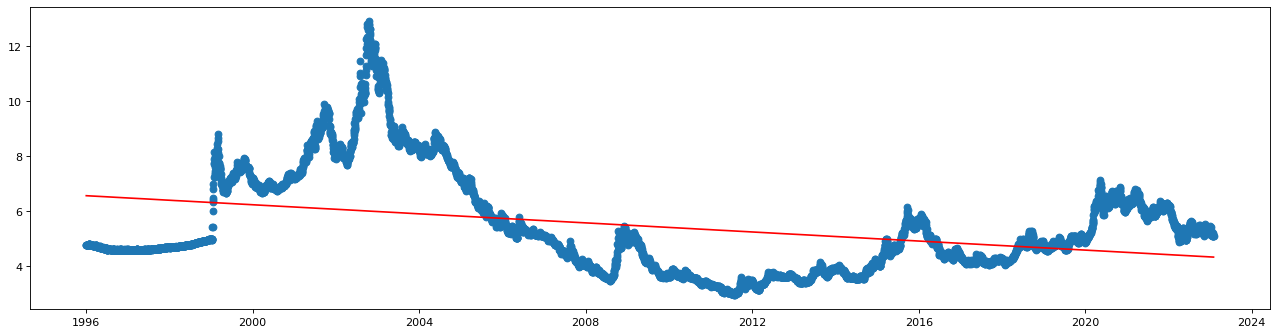

A equação prevista é Y = [6.55487739] + X * [[-0.00032803]] com um R2 de 0.12558664309386502


In [30]:
#thanks to https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d
from sklearn.linear_model import LinearRegression

df = cotacao_atual[['valor_cotacao_corrigida']]
df.reset_index(level=0, inplace=True)

#Ajusta o formato dos dados, e faz projecao linear
X = df.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

#Agora mostra os valores
plt.figure(figsize=(20, 5), dpi=80)
plt.scatter(cotacao_atual['data_cotacao'], Y)
plt.plot(cotacao_atual['data_cotacao'], Y_pred, color='red')
plt.show()

#Mostrando dados da equação
print(f"A equação prevista é Y = {linear_regressor.intercept_} + X * {linear_regressor.coef_} com um R2 de {linear_regressor.score(X, Y) }")



Com a correção da inflação, vemos que o dolar apresenta ate uma tendencia de queda! O que também é estranho, assim como pensar que ele sempre sobe. 

Minha hipotese é que desconsiderada a inflação, o valor ficaria oscilando em torno de uma média. Mas a gente ainda nao tirou todos os efeitos de inflação. Apesar da inflação americana ser baixa, ela existe. Vamos agora fazer a correção da inflação americana.

In [31]:
# Installing dependencies
!pip install datapackage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
#importa os valores da cotacao diretamente do site do banco central.
#Ajustes de formato, devido a localizacao para o portugues brasileiro
inflacao_eua = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CPIAUCSL&scale=left&cosd=1996-01-01&coed=2023-01-31&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2023-01-31&revision_date=2023-01-31&nd=1947-01-01")

#Convertendo a data, que esta formatada em string/object 
inflacao_eua



,DATE,CPIAUCSL
0,1996-01-01,154.700
1,1996-02-01,155.000
2,1996-03-01,155.500
3,1996-04-01,156.100
4,1996-05-01,156.400
...,...,...
320,2022-09-01,296.539
321,2022-10-01,297.987
322,2022-11-01,298.598
323,2022-12-01,298.990


In [33]:
# Corrigindo as colunas, e criando as mesmas colunas que os outros data frames
#em data de verdade
inflacao_eua['data_inflacao'] = pd.to_datetime(inflacao_eua['DATE'], format='%Y-%m-%d')

# para facilitar algumas operações, criando as colunas de mes e ano
inflacao_eua['numero_mes'] = pd.DatetimeIndex(inflacao_eua['data_inflacao']).month
inflacao_eua['numero_ano'] = pd.DatetimeIndex(inflacao_eua['data_inflacao']).year
inflacao_eua['numero_anomes'] = 100 * inflacao_eua['numero_ano'] + inflacao_eua['numero_mes']
inflacao_eua.set_index('numero_anomes')

#E para deixar organizado os nomes das colunas
#inflacao_eua['valor_inflacao'] = inflacao_eua['valor'] / 100

#limpando as colunas originais, que nao quero mais usar
#inflacao_eua = inflacao_eua[['data_inflacao', 'numero_mes', 'numero_ano', 'valor_inflacao']]

#vendo como ficou
inflacao_eua.head()

max_index = inflacao_eua['CPIAUCSL'].max()

inflacao_eua['valor_inflacao_acumulada_eua'] = inflacao_eua['CPIAUCSL'] / max_index
inflacao_eua


,DATE,CPIAUCSL,data_inflacao,numero_mes,numero_ano,numero_anomes,valor_inflacao_acumulada_eua
0,1996-01-01,154.700,1996-01-01,1,1996,199601,0.514747
1,1996-02-01,155.000,1996-02-01,2,1996,199602,0.515745
2,1996-03-01,155.500,1996-03-01,3,1996,199603,0.517409
3,1996-04-01,156.100,1996-04-01,4,1996,199604,0.519405
4,1996-05-01,156.400,1996-05-01,5,1996,199605,0.520404
...,...,...,...,...,...,...,...
320,2022-09-01,296.539,2022-09-01,9,2022,202209,0.986700
321,2022-10-01,297.987,2022-10-01,10,2022,202210,0.991518
322,2022-11-01,298.598,2022-11-01,11,2022,202211,0.993552
323,2022-12-01,298.990,2022-12-01,12,2022,202212,0.994856


FAzendo o novo ajuste para a inflacao americana, e replotando os graficos


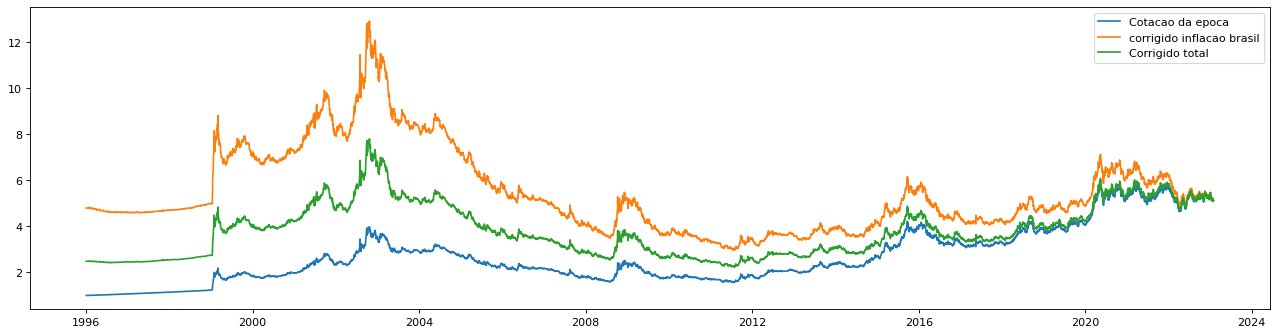

In [34]:
#juntando as tabelas e fazendo os cálculos
cotacao_atual_com_eua = pd.merge(cotacao_atual, inflacao_eua[['numero_anomes', 'valor_inflacao_acumulada_eua']], on='numero_anomes')
cotacao_atual_com_eua['valor_cotacao_corrigida_com_eua'] = cotacao_atual_com_eua['valor_cotacao_corrigida'] * cotacao_atual_com_eua['valor_inflacao_acumulada_eua']  
cotacao_atual_com_eua.head()

plt.figure(figsize=(20, 5), dpi=80)
plt.plot(cotacao_atual_com_eua['data_cotacao'], cotacao_atual_com_eua['valor_cotacao'], '-', label="Cotacao da epoca")
plt.plot(cotacao_atual_com_eua['data_cotacao'], cotacao_atual_com_eua['valor_cotacao_corrigida'], '-', label="corrigido inflacao brasil")
plt.plot(cotacao_atual_com_eua['data_cotacao'], cotacao_atual_com_eua['valor_cotacao_corrigida_com_eua'], '-', label="Corrigido total")
plt.legend()
plt.show()




Fazendo o mesmo exercicio agora, porem apenas com a linha totalmente corrigida (verde)

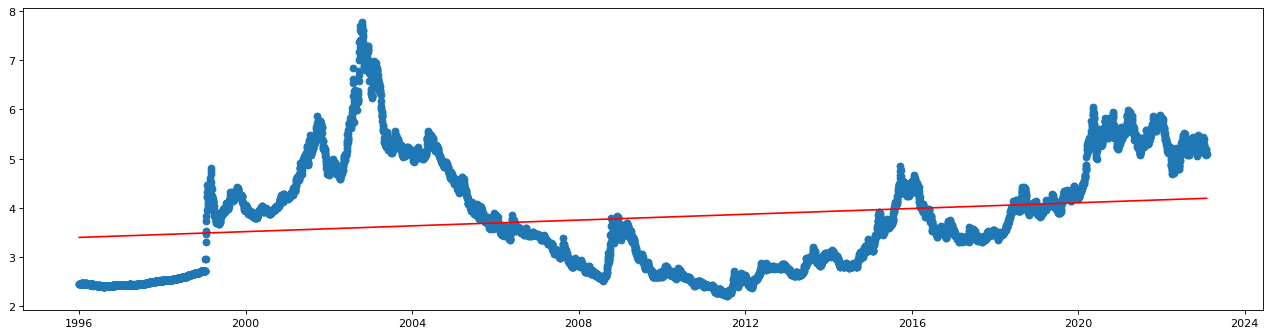

A equação prevista é Y = [3.39829147] + X * [[0.00011699]] com um R2 de 0.041415412360441994


In [35]:
#thanks to https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d
from sklearn.linear_model import LinearRegression


amostra = cotacao_atual_com_eua[cotacao_atual_com_eua['numero_ano'] >= 199]
df = amostra[['valor_cotacao_corrigida_com_eua']]

df.reset_index(level=0, inplace=True)

#Ajusta o formato dos dados, e faz projecao linear
X = df.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

#Agora mostra os valores
plt.figure(figsize=(20, 5), dpi=80)
plt.scatter(amostra['data_cotacao'], Y)
plt.plot(amostra['data_cotacao'], Y_pred, color='red')
plt.show()

#Mostrando dados da equação
print(f"A equação prevista é Y = {linear_regressor.intercept_} + X * {linear_regressor.coef_} com um R2 de {linear_regressor.score(X, Y) }")



Com isso, a hipotese proposta que o valor do dólar no longo prazo é estável, oscilando em torno de um valor comum, parece verdadeira. Foi preciso fazer os ajustes relativos a inflação dos dois paises e parece ser verdadeira afirmar que a cotação se altera pela diferença de inflação dos dois paises.


In [36]:
cotacao_media_esperada = cotacao_atual_com_eua['valor_cotacao_corrigida_com_eua'].mean()
cotacao_media_esperada

3.796099986114708

O valor médio do dolar de todo esse periodo é de R$ 3,60. Dificil acreditar que ele volte a esse patamar, mas são os que os dados e a simplificação absurda das hipoteses estão demonstrando.

Como bonus nessa elocubração, podemos agora usar esse valor medio para estimar a faixa de valores que o dolar deve oscilar.

In [37]:
cotacao_atual_com_eua['valor_diferenca_esperada'] = cotacao_atual_com_eua['valor_cotacao_corrigida_com_eua'] - cotacao_media_esperada
amostra_T = cotacao_atual_com_eua[['valor_diferenca_esperada']]

amostra_P = amostra_T[amostra_T['valor_diferenca_esperada'] >= 0].copy()
amostra_N = amostra_T[amostra_T['valor_diferenca_esperada'] < 0].copy()

#amostra_P.hist(bins=100)
#amostra_N.hist(bins=100)
amostra_P.sort_values('valor_diferenca_esperada', ascending=False, inplace=True, ignore_index=True)
amostra_N.sort_values('valor_diferenca_esperada', ascending=True, inplace=True, ignore_index=True)

p1p  = int(len(amostra_P)*0.01)
p5p  = int(len(amostra_P)*0.05)
p10p = int(len(amostra_P)*0.10)
p20p = int(len(amostra_P)*0.20)
p50p = int(len(amostra_P)*0.50)
p99p = int(len(amostra_P)*0.99)
#print(f"{p1p}, {p5p}, {p10p}, {p20p}, {p50p} e {p99p} de {len(amostra_P)}")

p1n  = int(len(amostra_N)*0.01)
p5n  = int(len(amostra_N)*0.05)
p10n = int(len(amostra_N)*0.10)
p20n = int(len(amostra_N)*0.20)
p50n = int(len(amostra_N)*0.50)
p99n = int(len(amostra_N)*0.99)
#print(f"{p1n}, {p5n}, {p10n}, {p20n}, {p50n} e {p99n} de {len(amostra_N)}")


v_max_1 = amostra_P.iloc[p1p] + cotacao_media_esperada
v_max_5 = amostra_P.iloc[p5p] + cotacao_media_esperada
v_max_10 = amostra_P.iloc[p10p] + cotacao_media_esperada
v_max_20 = amostra_P.iloc[p20p] + cotacao_media_esperada
v_max_50 = amostra_P.iloc[p50p] + cotacao_media_esperada
v_max_99 = amostra_P.iloc[p99p] + cotacao_media_esperada

v_min_1 = amostra_N.iloc[p1n] + cotacao_media_esperada
v_min_5 = amostra_N.iloc[p5n] + cotacao_media_esperada
v_min_10 = amostra_N.iloc[p10n] + cotacao_media_esperada
v_min_20 = amostra_N.iloc[p20n] + cotacao_media_esperada
v_min_50 = amostra_N.iloc[p50n] + cotacao_media_esperada
v_min_99 = amostra_N.iloc[p99n] + cotacao_media_esperada

print(f"99% [{v_min_1['valor_diferenca_esperada']} {v_max_1['valor_diferenca_esperada']}]")
print(f"95% [{v_min_5['valor_diferenca_esperada']} {v_max_5['valor_diferenca_esperada']}]")
print(f"90% [{v_min_10['valor_diferenca_esperada']} {v_max_10['valor_diferenca_esperada']}]")
print(f"80% [{v_min_20['valor_diferenca_esperada']} {v_max_20['valor_diferenca_esperada']}]")
print(f"50% [{v_min_50['valor_diferenca_esperada']} {v_max_50['valor_diferenca_esperada']}]")
print(f"1% [{v_min_99['valor_diferenca_esperada']} {v_max_99['valor_diferenca_esperada']}]")


99% [2.269682696083153 7.198082593906846]
95% [2.407953100709694 6.193386569117043]
90% [2.4299190194929294 5.7353229295650285]
80% [2.4953982221861892 5.428921354666842]
50% [2.808990560284271 4.806334514719177]
1% [3.765652545868163 3.816993833676687]


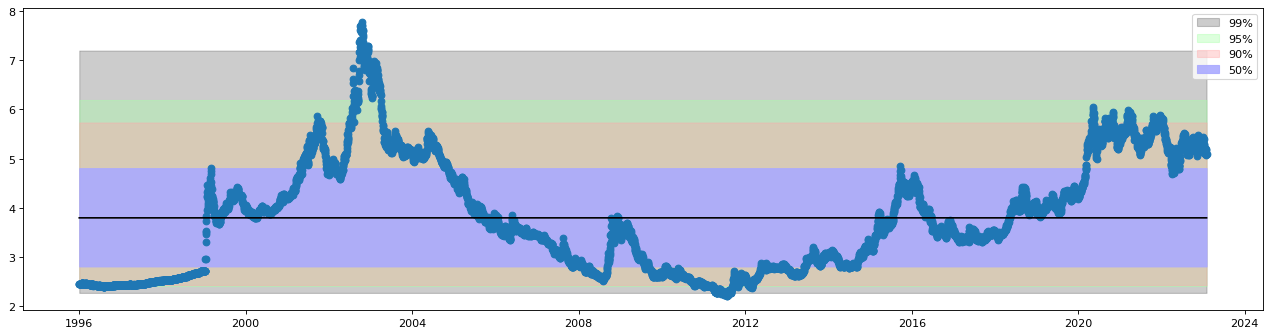

In [38]:
#Agora mostra os valores
plt.figure(figsize=(20, 5), dpi=80)

amostra['cotacao_media_esperada'] = cotacao_media_esperada
amostra['cotacao_min_90'] = v_min_10['valor_diferenca_esperada']

plt.plot(amostra['data_cotacao'], amostra['cotacao_media_esperada'], color='black')
plt.fill_between(amostra['data_cotacao'],  v_min_1['valor_diferenca_esperada'], v_max_1['valor_diferenca_esperada'], alpha=0.2, color='#000', label="99%")
plt.fill_between(amostra['data_cotacao'],  v_min_5['valor_diferenca_esperada'], v_max_5['valor_diferenca_esperada'], alpha=0.4, color='#AFA', label="95%")
plt.fill_between(amostra['data_cotacao'],  v_min_10['valor_diferenca_esperada'], v_max_10['valor_diferenca_esperada'], alpha=0.4, color='#FAA', label="90%")
plt.fill_between(amostra['data_cotacao'],  v_min_50['valor_diferenca_esperada'], v_max_50['valor_diferenca_esperada'], alpha=0.9, color='#AAF', label="50%")

plt.legend()
plt.scatter(amostra['data_cotacao'], Y)
plt.show()



Links e fontes para ajudar a subsidiar esse texto

1.   https://dadosabertos.bcb.gov.br/dataset/10813-taxa-de-cambio---livre---dolar-americano-compra/resource/f02d92bd-bf7d-4bfe-b1c3-06938f7012c2
2.   https://www.contabeis.com.br/tabelas/salario-minimo/
3.   https://economia.uol.com.br/noticias/infomoney/2014/07/15/veja-quanto-valiam-os-carros-em-1994-tinha-uno-saindo-por-mais-de-r-100-mil.htm
4.   https://dadosabertos.bcb.gov.br/dataset/4466-indice-nacional-de-precos-ao-consumidor-amplo-ipca---nucleo-medias-aparadas-com-suavizacao/resource/4d877181-41c5-41bc-8dfd-9dd035c108ef
5. https://fred.stlouisfed.org/series/CPIAUCSL

